In [1]:
import sys
import os
from collections import defaultdict
import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
from glmpca import glmpca
from itertools import combinations
import torch

import sys
from importlib import reload

In [2]:
import gaston
from gaston import neural_net,cluster_plotting, dp_related, segmented_fit, model_selection
from gaston import binning_and_plotting, isodepth_scaling, run_slurm_scripts, parse_adata
from gaston import spatial_gene_classification, plot_cell_types, filter_genes, process_NN_output

import seaborn as sns
import math

/opt/anaconda3/envs/spatial/lib/python3.9/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


### Make/ load data

In [3]:
from scipy.io import mmread

datadir = '/Users/allywang/Desktop/work/S2025/SpaceOracle/data/human_tonsil/expression/644751ebb67df4748764a4a1'
barcodes = pd.read_csv(os.path.join(datadir, 'barcodes.tsv.gz'), header=None)
genes = pd.read_csv(os.path.join(datadir, 'features.tsv.gz'), sep='\t', header=None)
matrix = mmread(os.path.join(datadir, 'matrix.mtx.gz'))

adata = sc.AnnData(matrix.tocsr().T)
adata.obs_names = barcodes[0]
adata.var_names = genes[1]

adata

AnnData object with n_obs × n_vars = 9360 × 36601

In [4]:
clusterdir = '/Users/allywang/Desktop/work/S2025/SpaceOracle/data/human_tonsil/cluster'
cluster = pd.read_csv(os.path.join(clusterdir, 'HumanTonsil_spatial.csv'), header=None, skiprows=2)

barcodes = cluster[0]
adata = adata[barcodes, :]
adata

View of AnnData object with n_obs × n_vars = 5778 × 36601

In [5]:
adata = adata.copy()
adata.obs['cluster'] = cluster[3].values
adata.obsm['spatial'] = cluster[[1,2]].values
adata

/opt/anaconda3/envs/spatial/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 5778 × 36601
    obs: 'cluster'
    obsm: 'spatial'

In [6]:
adata.var_names_make_unique()

In [7]:
# important_genes = list(
#   sc.read_h5ad('/Users/allywang/Desktop/work/S2025/SpaceOracle/data/training_data_2025/snrna_human_tonsil.h5ad').var_names)
# adata = adata[:, important_genes]
# adata

In [7]:
clusters = adata.obs['cluster'].unique()
n_clusters = len(clusters)
n_clusters 

13

### PCA

In [9]:
# counts_mat=np.load('cerebellum_data/cerebellum_counts_mat.npy') # N x G UMI count array
# coords_mat=np.load('cerebellum_data/cerebellum_coords_mat.npy') # N x 2 spatial coordinate matrix
# gene_labels=np.load('cerebellum_data/cerebellum_gene_labels.npy', allow_pickle=True) # list of names for G genes

counts_mat = adata.X.toarray()
coords_mat = adata.obsm['spatial']
gene_labels = adata.var_names

In [10]:
# # OPTIONAL: filter out cells with UMI below spot_umi_threshold
# spot_umi_threshold=0

# spots_to_keep=np.sum(counts_mat, axis=1)>=spot_umi_threshold
# print(f'number of removed spots: {counts_mat.shape[0]-spots_to_keep.sum()}')
# counts_mat=counts_mat[spots_to_keep,:]
# coords_mat=coords_mat[spots_to_keep,:]

In [13]:
# GLM-PCA parameters
num_dims=n_clusters *2 # 2 * number of clusters
penalty=500 # may need to increase if this is too small

# CHANGE THESE PARAMETERS TO REDUCE RUNTIME
num_iters=30
eps=1e-4
num_genes=30000

counts_mat_glmpca=counts_mat[:,np.argsort(np.sum(counts_mat, axis=0))[-num_genes:]]
glmpca_res=glmpca.glmpca(counts_mat_glmpca.T, num_dims, fam="poi", penalty=penalty, verbose=True,
                        ctl = {"maxIter":num_iters, "eps":eps, "optimizeTheta":True})
A = glmpca_res['factors'] # should be of size N x num_dims, where each column is a PC

np.save('tonsil_data/glmpca.npy', A)

Iteration: 0 | deviance=7.5549E+7
Iteration: 1 | deviance=7.5549E+7
Iteration: 2 | deviance=7.5548E+7
Iteration: 3 | deviance=7.4379E+7
Iteration: 4 | deviance=6.9366E+7
Iteration: 5 | deviance=6.5407E+7
Iteration: 6 | deviance=6.3740E+7
Iteration: 7 | deviance=6.2955E+7
Iteration: 8 | deviance=6.2588E+7
Iteration: 9 | deviance=6.2384E+7
Iteration: 10 | deviance=6.2259E+7
Iteration: 11 | deviance=6.2176E+7
Iteration: 12 | deviance=6.2117E+7
Iteration: 13 | deviance=6.2073E+7
Iteration: 14 | deviance=6.2040E+7
Iteration: 15 | deviance=6.2013E+7
Iteration: 16 | deviance=6.1993E+7
Iteration: 17 | deviance=6.1976E+7
Iteration: 18 | deviance=6.1963E+7
Iteration: 19 | deviance=6.1953E+7
Iteration: 20 | deviance=6.1944E+7
Iteration: 21 | deviance=6.1937E+7


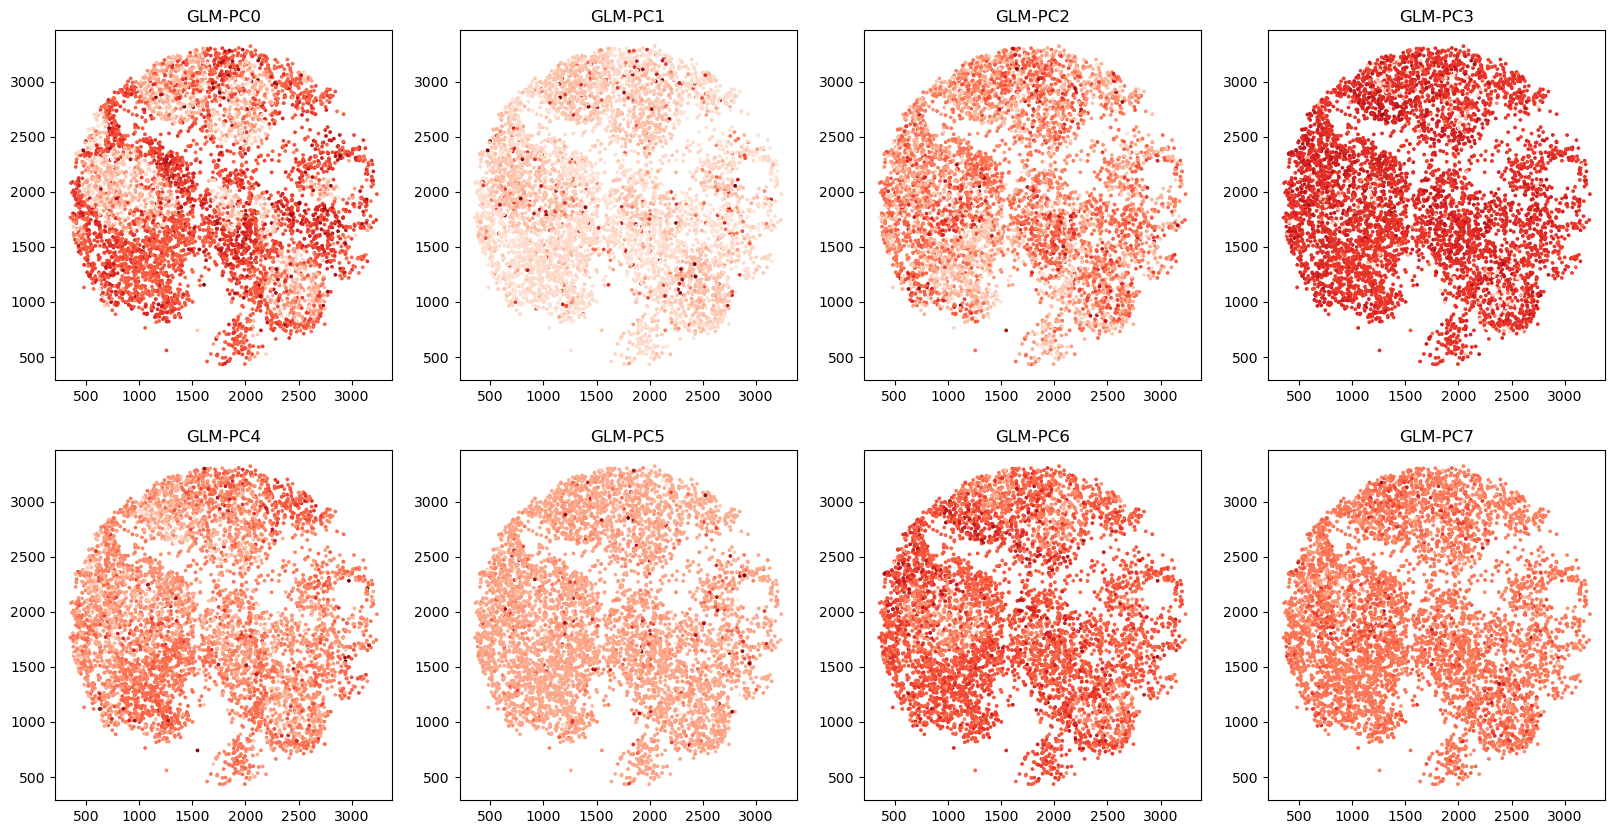

In [14]:
# visualize top GLM-PCs
R=2
C=4
fig,axs=plt.subplots(R,C,figsize=(20,10))
for r in range(R):
    for c in range(C):
        i=r*C+c
        axs[r,c].scatter(coords_mat[:,0], coords_mat[:,1], c=A[:,i],cmap='Reds',s=3)
        axs[r,c].set_title(f'GLM-PC{i}')

### Train in notebook

In [15]:
# Load N x G matrix A of GLM-PCs, and N x 2 matrix S
# A=np.load('tutorial_outputs/glmpca.npy') # GLM-PCA results from above
A=np.load('tonsil_data/glmpca.npy') # GLM-PCA results used in manuscript
S=coords_mat

# z-score normalize S and A
S_torch, A_torch = neural_net.load_rescale_input_data(S,A)

In [16]:
######################################
# NEURAL NET PARAMETERS (USER CAN CHANGE)
# architectures are encoded as list, eg [20,20] means two hidden layers of size 20 hidden neurons
isodepth_arch=[20,20] # architecture for isodepth neural network d(x,y) : R^2 -> R 
expression_fn_arch=[20,20] # architecture for 1-D expression function h(w) : R -> R^G

num_epochs = 10000 # number of epochs to train NN (NOTE: it is sometimes beneficial to train longer)
checkpoint = 500 # save model after number of epochs = multiple of checkpoint
out_dir='tonsil_outputs' # folder to save model runs
optimizer = "adam"
num_restarts=30

######################################

seed_list=range(num_restarts)
for seed in seed_list:
    print(f'training neural network for seed {seed}')
    out_dir_seed=f"{out_dir}/rep{seed}"
    os.makedirs(out_dir_seed, exist_ok=True)
    mod, loss_list = neural_net.train(S_torch, A_torch,
                          S_hidden_list=isodepth_arch, A_hidden_list=expression_fn_arch, 
                          epochs=num_epochs, checkpoint=checkpoint, 
                          save_dir=out_dir_seed, optim=optimizer, seed=seed, save_final=True)

training neural network for seed 0
training neural network for seed 1
training neural network for seed 2
training neural network for seed 3
training neural network for seed 4
training neural network for seed 5
training neural network for seed 6
training neural network for seed 7
training neural network for seed 8
training neural network for seed 9
training neural network for seed 10
training neural network for seed 11
training neural network for seed 12
training neural network for seed 13
training neural network for seed 14
training neural network for seed 15
training neural network for seed 16
training neural network for seed 17
training neural network for seed 18
training neural network for seed 19
training neural network for seed 20
training neural network for seed 21
training neural network for seed 22
training neural network for seed 23
training neural network for seed 24
training neural network for seed 25
training neural network for seed 26
training neural network for seed 27
tr

### Visualize model results

/opt/anaconda3/envs/spatial/lib/python3.9/site-packages/gaston/process_NN_output.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  St=torch.load(os.path.join(folder_path,


best model: tonsil_outputs/rep13
Kneedle number of domains: 4


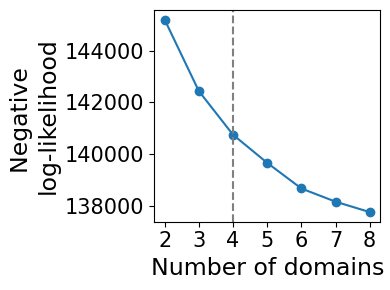

In [8]:
gaston_model, A, S= process_NN_output.process_files('tonsil_outputs')
model_selection.plot_ll_curve(gaston_model, A, S, max_domain_num=8, start_from=2)

In [9]:
# CHANGE FOR YOUR APPLICATION: use number of domains from above!
num_layers=4

# identify labels
gaston_isodepth, gaston_labels=dp_related.get_isodepth_labels(gaston_model,A,S,num_layers)

# DATASET-SPECIFIC: so domains are ordered oligodendrocyte to molecular, with increasing isodepth
gaston_isodepth=np.max(gaston_isodepth) - gaston_isodepth
gaston_labels=(num_layers-1)-gaston_labels

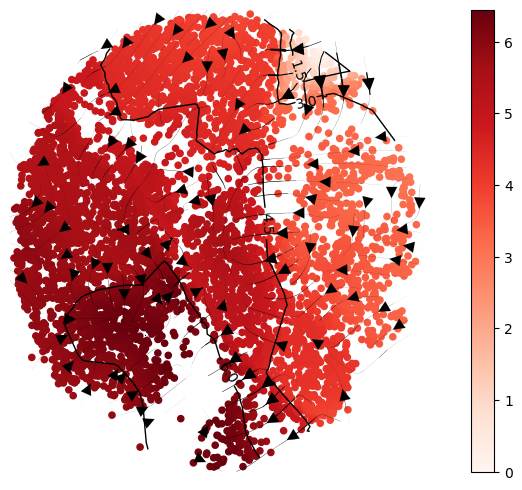

In [10]:
show_streamlines=True
cluster_plotting.plot_isodepth(gaston_isodepth, S, gaston_model, figsize=(7,6), streamlines=show_streamlines, cmap='Reds',
                              neg_gradient=True) # since we did isodepth -> -1*isodepth above, we also need to do gradient -> -1*gradient

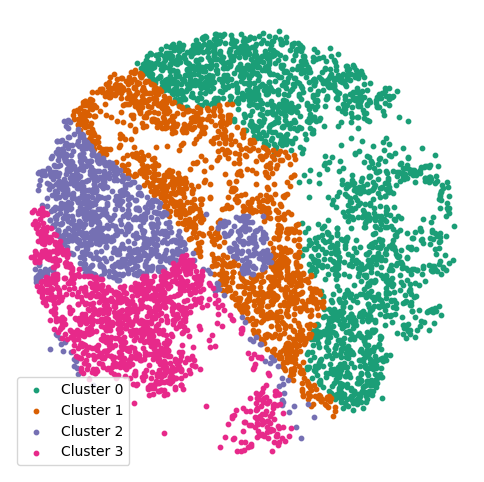

In [11]:
# labels=['Oligodendrocyte layer', 'Granule layer', 'Purkinje-Bergmann layer', 'Molecular layer']
labels=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3']

# WITHOUT CUSTOM COLORS
cluster_plotting.plot_clusters(gaston_labels, S, figsize=(6,6), colors=None, 
                               color_palette=plt.cm.Dark2, s=10,labels=labels,lgd=True)

# # TO PLOT WITH CUSTOM COLORS:
# domain_colors=['C6', 'mediumseagreen', 'darkmagenta', 'C8']
# cluster_plotting.plot_clusters(gaston_labels, S, figsize=(6,6), 
#                                colors=domain_colors, s=10,labels=labels,lgd=True)

In [ ]:
cell_type_df=pd.read_csv('cerebellum_data/cell_type_df.csv', index_col=0)
cell_type_df